In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
# from IPython.display import clear_output
import os
import random
from tqdm.auto import tqdm
from timeit import default_timer as timer

import tensorflow as tf
import keras
import keras.backend as K
import keras.layers as KL
# import keras.engine as KE
import keras.models as KM
from tensorflow.keras.initializers import GlorotNormal

print("TensorFlow version:", tf.__version__)

Mounted at /content/drive
TensorFlow version: 2.13.0


In [2]:
!pip install wandb
import wandb
!wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 31.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=57a0e89bb92555e07737a077d88b035ec2aeb280d62c78cadcd6f2647f5867bc
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
import sys
sys.path.append('/content/drive/My Drive/kaggle/contrail_detector/')
import utils
import models
from configs import alt_wnet_unet_config, Path


# 1. Training the Model

In [4]:
train_metadata = pd.read_json("/content/drive/MyDrive/kaggle/contrail_detector/data/train_metadata.json", dtype={'record_id': 'str'})
valid_metadata = pd.read_json("/content/drive/MyDrive/kaggle/contrail_detector/data/valid_metadata.json", dtype={'record_id': 'str'})

In [5]:
train_metadata = train_metadata.loc[train_metadata.contrail_exists == 1]
valid_metadata = valid_metadata.loc[valid_metadata.contrail_exists == 1]

In [6]:
train_metadata.head()

,record_id,projection_wkt,row_min,row_size,col_min,col_size,timestamp,contrail_exists
2,6808716999707654664,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4356032.0,-1996.296997,367297.18750,1928.051147,2020-03-04 21:10:00,1
3,8019228729201913883,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4691404.5,-2039.323608,516009.65625,1887.738647,2019-10-17 10:00:00,1
6,7928274349669974651,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4812987.0,-2071.388916,625964.25000,1856.775879,2019-04-18 22:30:00,1
8,5864608195686402552,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",3305261.0,-1986.308350,404203.18750,1931.237305,2020-02-24 17:30:00,1
9,8421241911447299269,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4135470.5,-2063.630371,698077.93750,1862.927612,2019-04-30 18:40:00,1


In [7]:
def load_data(record_id, path):
    # make path objects
    record_id = record_id.numpy().decode('utf-8')
    path = path.numpy().decode('utf-8')
    image_path = path + "masked_image/" + str(record_id) + ".npy"
    mask_path = path + "mask/" + str(record_id) + ".npy"
    # load the images and masks for the correspoding paths
    image = np.load(image_path)[...,alt_wnet_unet_config.n_times_before, :].astype(np.float32)
    mask = np.load(mask_path).astype(np.float32)
    return image, mask

def augment_data(image, mask):
    # random flip
    image_mask_concat = tf.concat([image, mask], axis = -1)
    image_mask_concat = tf.image.random_flip_left_right(image_mask_concat)
    image_mask_concat = tf.image.random_flip_up_down(image_mask_concat)
    # random crop
    cropped = tf.image.random_crop(image_mask_concat, size=[(alt_wnet_unet_config.image_shape[0]*3)//4,(alt_wnet_unet_config.image_shape[1]*3)//4, 4])
    image_mask_concat = tf.image.resize(cropped, [alt_wnet_unet_config.image_shape[0], alt_wnet_unet_config.image_shape[1]])

    image = image_mask_concat[..., :-1]
    mask = image_mask_concat[..., -1]
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.cast(mask > 0.5, tf.float32)
    return image, mask

In [8]:
id_to_data = lambda record_id, path : tf.py_function(func = load_data, inp = [record_id, path], Tout = (tf.float32, tf.float32))
train_id = train_metadata.record_id.to_list()
valid_id = valid_metadata.record_id.to_list()

n = len(train_id)-(len(train_id)%20)
m = len(valid_id)-(len(valid_id)%20)

train_id = train_id[:n]
valid_id = valid_id[:m]

train_path = len(train_id)*[Path.train]
valid_path = len(valid_id)*[Path.valid]

train_id_dataset = tf.data.Dataset.from_tensor_slices(train_id)
train_path_dataset = tf.data.Dataset.from_tensor_slices(train_path)

valid_id_dataset = tf.data.Dataset.from_tensor_slices(valid_id)
valid_path_dataset = tf.data.Dataset.from_tensor_slices(valid_path)

train_dataset = tf.data.Dataset.zip((train_id_dataset, train_path_dataset)).map(id_to_data).map(augment_data).shuffle(alt_wnet_unet_config.buffer_size).batch(alt_wnet_unet_config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = tf.data.Dataset.zip((valid_id_dataset, valid_path_dataset)).map(id_to_data).shuffle(alt_wnet_unet_config.buffer_size).batch(alt_wnet_unet_config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)




In [9]:
len(train_id), len(valid_id)

(180, 40)

In [10]:
def dice_score(y_true, y_pred, thr=0.5, epsilon=1e-6):
    # Thresholding predictions
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_pred = tf.cast(y_pred > thr, tf.float32)

    # Flattening tensors
    y_true = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])

    # Computing intersections and unions
    intersections = tf.reduce_sum(y_true * y_pred, axis=1)
    unions = tf.reduce_sum(y_true, axis=1) + tf.reduce_sum(y_pred, axis=1)

    # Computing Dice scores
    dices = (2. * intersections + epsilon) / (unions + epsilon)

    return tf.reduce_mean(dices)

# Define Dice Loss
# we do not binarize the prediction for dice 'loss' calculation
def dice_loss(y_true, y_pred, epsilon=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

    return tf.reduce_mean(1 - (numerator + epsilon) / (denominator + epsilon))

# Binary Cross Entropy Loss
bce = tf.keras.losses.BinaryCrossentropy(from_logits = False)

# Combined Loss
def combined_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])

    return alpha * bce(y_true, y_pred) + beta * dice_loss(y_true, y_pred)

In [11]:
@tf.function
def train_step(inputs, labels, model, loss_fn, optimizer):
  with tf.GradientTape() as tape:
    predictions = model(inputs, training = True)[...,-1:]
    loss_value = loss_fn(labels, predictions)
  gradients = tape.gradient(loss_value, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss_value

@tf.function
def valid_step(inputs, labels, model, loss_fn, metric_fn):
  predictions = model(inputs, training = False)[...,-1:]
  loss_value = loss_fn(labels, predictions)
  metric_value = metric_fn(labels, predictions, thr = 0.5)
  return loss_value, metric_value

def train_model(train_dataset, valid_dataset, model, loss_fn, metric_fn, optimizer, epochs, checkpoint_directory, log_directory, resume = None, max_to_keep=3):

  # printout which device the model is on
  print(model.layers[0].weights[0].device)

  train_losses = []
  valid_losses = []
  valid_metrics = []

  # Create a checkpoint object and checkpoint manager
  checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                   optimizer=optimizer,
                                   model=model)
  manager = tf.train.CheckpointManager(checkpoint,
                                       checkpoint_directory,
                                       max_to_keep)

  # restore the last checkpoint if there is one
  checkpoint.restore(manager.latest_checkpoint)
  if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
  else:
    print("Initializing from scratch.")

  train_summary_writer = tf.summary.create_file_writer(log_directory)
  valid_summary_writer = tf.summary.create_file_writer(log_directory)

  # Initialize W&B run
  wandb.init(project='contrail_detector', name='alt_wnet_unet', resume = resume)


  # training loop starts
  for epoch in range(epochs):
    start_time = timer()
    checkpoint.step.assign_add(1)
    print(f"\n Epoch {checkpoint.step.numpy()} : \n")

    # initialize losses and metrics
    train_total_loss = 0
    valid_total_loss = 0
    valid_total_metric = 0
    train_n_batches = 0
    valid_n_batches = 0

    # train loop
    for step, (X_batch, y_batch) in enumerate(tqdm(train_dataset, desc='Training', position=0)):
      loss_value = train_step(X_batch, y_batch, model, loss_fn, optimizer)

      train_total_loss += loss_value
      train_n_batches += 1

      if step % 1 == 0: # print every 1 batches
        print(f"batch {step}, train_loss: {loss_value:.4f}")

    # valid loop
    for step, (X_batch, y_batch) in enumerate(tqdm(valid_dataset, desc='Validation', position=0)):
      loss_value, metric_value = valid_step(X_batch, y_batch, model, loss_fn, metric_fn)
      valid_total_loss += loss_value
      valid_total_metric += metric_value
      valid_n_batches += 1

    train_epoch_loss = train_total_loss / train_n_batches
    valid_epoch_loss = valid_total_loss / valid_n_batches
    valid_epoch_metric = valid_total_metric / valid_n_batches

    train_losses.append(train_epoch_loss)
    valid_losses.append(valid_epoch_loss)
    valid_metrics.append(valid_epoch_metric)

    # Log training metrics for the epoch
    with train_summary_writer.as_default():
        tf.summary.scalar('train_loss', train_epoch_loss, step=checkpoint.step.numpy())

    # Log validation metrics for the epoch
    with valid_summary_writer.as_default():
        tf.summary.scalar('valid_loss', valid_epoch_loss, step=checkpoint.step.numpy())
        tf.summary.scalar('valid_metric', valid_epoch_metric, step=checkpoint.step.numpy())

    # Log metrics to W&B
    wandb.log({
              'train_loss': train_epoch_loss.numpy(),
              'valid_loss': valid_epoch_loss.numpy(),
              'valid_metric': valid_epoch_metric.numpy(),
              'epoch': checkpoint.step.numpy()
          })
    #save checkpoint
    save_path = manager.save()

    # Save checkpoint to W&B as an artifact
    artifact = wandb.Artifact(f'alt_wnet_unet-epoch-{checkpoint.step.numpy()}-checkpoint', type='model')
    # Add the index file
    artifact.add_file(save_path + ".index")

    # Add the data file
    artifact.add_file(save_path + ".data-00000-of-00001")

    wandb.log_artifact(artifact)
    end_time = timer()

    # print out results
    print("\n")
    print("  (Results)")
    print(f"  train_loss: {train_epoch_loss:.4f}")
    print(f"  valid_loss: {valid_epoch_loss:.4f}")
    print(f"  valid_metric: {valid_epoch_metric:.4f}")
    print("\n")
    print("  (Time)")
    print("  start_time : ", start_time)
    print("  end_time : ", end_time)
    print("-----------------------------------------------------------------")

  # Finish the W&B run
  wandb.finish()

  return train_losses, valid_losses, valid_metrics

In [12]:
model = models.unet()
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(alt_wnet_unet_config.initial_learning_rate,
                                                        decay_steps=alt_wnet_unet_config.decay_steps,
                                                        alpha=alt_wnet_unet_config.alpha)
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
loss_fn = lambda labels, predictions : dice_loss(labels, predictions)
metric_fn = lambda labels, predictions,thr : dice_score(labels, predictions, thr)

In [ ]:
checkpoint_directory = "/content/drive/MyDrive/kaggle/contrail_detector/checkpoint/alt_wnet_unet"
log_directory = "/content/drive/MyDrive/kaggle/contrail_detector/log/alt_wnet_unet"
train_losses, valid_losses, valid_metrics = train_model(train_dataset, valid_dataset, model,
                                                        loss_fn, metric_fn, optimizer,
                                                        epochs=alt_wnet_unet_config.n_epochs,
                                                        checkpoint_directory = checkpoint_directory,
                                                        log_directory = log_directory,
                                                        resume = None)

/job:localhost/replica:0/task:0/device:GPU:0
Initializing from scratch.


wandb: Currently logged in as: jun23ird. Use `wandb login --relogin` to force relogin



 Epoch 1 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9918
batch 1, train_loss: 0.9927
batch 2, train_loss: 0.9836
batch 3, train_loss: 0.9878
batch 4, train_loss: 0.9854
batch 5, train_loss: 0.9913
batch 6, train_loss: 0.9852
batch 7, train_loss: 0.9883
batch 8, train_loss: 0.9912


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9886
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  963.622649197
  end_time :  1257.637858907
-----------------------------------------------------------------

 Epoch 2 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9922
batch 1, train_loss: 0.9892
batch 2, train_loss: 0.9877
batch 3, train_loss: 0.9870
batch 4, train_loss: 0.9869
batch 5, train_loss: 0.9895
batch 6, train_loss: 0.9902
batch 7, train_loss: 0.9857
batch 8, train_loss: 0.9920


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9889
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1257.644734495
  end_time :  1267.096435591
-----------------------------------------------------------------

 Epoch 3 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9918
batch 1, train_loss: 0.9911
batch 2, train_loss: 0.9828
batch 3, train_loss: 0.9848
batch 4, train_loss: 0.9944
batch 5, train_loss: 0.9849
batch 6, train_loss: 0.9876
batch 7, train_loss: 0.9817
batch 8, train_loss: 0.9941


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9881
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1267.101504367
  end_time :  1275.495905798
-----------------------------------------------------------------

 Epoch 4 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9898
batch 1, train_loss: 0.9929
batch 2, train_loss: 0.9848
batch 3, train_loss: 0.9849
batch 4, train_loss: 0.9894
batch 5, train_loss: 0.9898
batch 6, train_loss: 0.9845
batch 7, train_loss: 0.9879
batch 8, train_loss: 0.9926


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9885
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1275.501344626
  end_time :  1287.208659152
-----------------------------------------------------------------

 Epoch 5 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9901
batch 1, train_loss: 0.9933
batch 2, train_loss: 0.9843
batch 3, train_loss: 0.9880
batch 4, train_loss: 0.9919
batch 5, train_loss: 0.9885
batch 6, train_loss: 0.9862
batch 7, train_loss: 0.9899
batch 8, train_loss: 0.9904


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9892
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1287.213746526
  end_time :  1295.073749283
-----------------------------------------------------------------

 Epoch 6 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9932
batch 1, train_loss: 0.9872
batch 2, train_loss: 0.9845
batch 3, train_loss: 0.9882
batch 4, train_loss: 0.9885
batch 5, train_loss: 0.9891
batch 6, train_loss: 0.9878
batch 7, train_loss: 0.9886
batch 8, train_loss: 0.9910


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9887
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1295.079850429
  end_time :  1302.901283148
-----------------------------------------------------------------

 Epoch 7 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9909
batch 1, train_loss: 0.9935
batch 2, train_loss: 0.9812
batch 3, train_loss: 0.9859
batch 4, train_loss: 0.9899
batch 5, train_loss: 0.9924
batch 6, train_loss: 0.9916
batch 7, train_loss: 0.9830
batch 8, train_loss: 0.9920


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9889
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1302.907326751
  end_time :  1313.332959128
-----------------------------------------------------------------

 Epoch 8 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9941
batch 1, train_loss: 0.9859
batch 2, train_loss: 0.9866
batch 3, train_loss: 0.9897
batch 4, train_loss: 0.9881
batch 5, train_loss: 0.9901
batch 6, train_loss: 0.9851
batch 7, train_loss: 0.9872
batch 8, train_loss: 0.9900


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9885
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1313.338622784
  end_time :  1321.458214372
-----------------------------------------------------------------

 Epoch 9 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9896
batch 1, train_loss: 0.9932
batch 2, train_loss: 0.9809
batch 3, train_loss: 0.9895
batch 4, train_loss: 0.9859
batch 5, train_loss: 0.9920
batch 6, train_loss: 0.9840
batch 7, train_loss: 0.9880
batch 8, train_loss: 0.9895


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9881
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1321.465127822
  end_time :  1329.36390172
-----------------------------------------------------------------

 Epoch 10 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9911
batch 1, train_loss: 0.9920
batch 2, train_loss: 0.9876
batch 3, train_loss: 0.9852
batch 4, train_loss: 0.9873
batch 5, train_loss: 0.9893
batch 6, train_loss: 0.9875
batch 7, train_loss: 0.9879
batch 8, train_loss: 0.9914


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9888
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1329.371792644
  end_time :  1337.350959831
-----------------------------------------------------------------

 Epoch 11 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9909
batch 1, train_loss: 0.9892
batch 2, train_loss: 0.9868
batch 3, train_loss: 0.9885
batch 4, train_loss: 0.9890
batch 5, train_loss: 0.9907
batch 6, train_loss: 0.9857
batch 7, train_loss: 0.9882
batch 8, train_loss: 0.9920


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9890
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1337.35792089
  end_time :  1345.717868963
-----------------------------------------------------------------

 Epoch 12 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9903
batch 1, train_loss: 0.9876
batch 2, train_loss: 0.9896
batch 3, train_loss: 0.9914
batch 4, train_loss: 0.9871
batch 5, train_loss: 0.9896
batch 6, train_loss: 0.9876
batch 7, train_loss: 0.9852
batch 8, train_loss: 0.9922


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9889
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1345.725015607
  end_time :  1353.68312571
-----------------------------------------------------------------

 Epoch 13 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9906
batch 1, train_loss: 0.9880
batch 2, train_loss: 0.9885
batch 3, train_loss: 0.9881
batch 4, train_loss: 0.9860
batch 5, train_loss: 0.9934
batch 6, train_loss: 0.9841
batch 7, train_loss: 0.9903
batch 8, train_loss: 0.9902


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9888
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1353.689288034
  end_time :  1362.980255908
-----------------------------------------------------------------

 Epoch 14 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9906
batch 1, train_loss: 0.9865
batch 2, train_loss: 0.9878
batch 3, train_loss: 0.9902
batch 4, train_loss: 0.9893
batch 5, train_loss: 0.9908
batch 6, train_loss: 0.9886
batch 7, train_loss: 0.9847
batch 8, train_loss: 0.9925


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9890
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1362.988017508
  end_time :  1370.989846843
-----------------------------------------------------------------

 Epoch 15 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9927
batch 1, train_loss: 0.9870
batch 2, train_loss: 0.9876
batch 3, train_loss: 0.9893
batch 4, train_loss: 0.9864
batch 5, train_loss: 0.9921
batch 6, train_loss: 0.9875
batch 7, train_loss: 0.9854
batch 8, train_loss: 0.9941


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9891
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1370.99477731
  end_time :  1378.767833093
-----------------------------------------------------------------

 Epoch 16 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9895
batch 1, train_loss: 0.9893
batch 2, train_loss: 0.9877
batch 3, train_loss: 0.9901
batch 4, train_loss: 0.9900
batch 5, train_loss: 0.9881
batch 6, train_loss: 0.9851
batch 7, train_loss: 0.9836
batch 8, train_loss: 0.9948


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9887
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1378.775500278
  end_time :  1386.882633159
-----------------------------------------------------------------

 Epoch 17 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9898
batch 1, train_loss: 0.9894
batch 2, train_loss: 0.9877
batch 3, train_loss: 0.9910
batch 4, train_loss: 0.9919
batch 5, train_loss: 0.9855
batch 6, train_loss: 0.9881
batch 7, train_loss: 0.9861
batch 8, train_loss: 0.9927


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9891
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1386.88992417
  end_time :  1394.902175002
-----------------------------------------------------------------

 Epoch 18 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9935
batch 1, train_loss: 0.9910
batch 2, train_loss: 0.9818
batch 3, train_loss: 0.9873
batch 4, train_loss: 0.9862
batch 5, train_loss: 0.9908
batch 6, train_loss: 0.9834
batch 7, train_loss: 0.9882
batch 8, train_loss: 0.9938


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9884
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1394.909382188
  end_time :  1402.804455311
-----------------------------------------------------------------

 Epoch 19 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9889
batch 1, train_loss: 0.9933
batch 2, train_loss: 0.9837
batch 3, train_loss: 0.9877
batch 4, train_loss: 0.9880
batch 5, train_loss: 0.9892
batch 6, train_loss: 0.9875
batch 7, train_loss: 0.9898
batch 8, train_loss: 0.9899


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9887
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1402.814083625
  end_time :  1411.773883787
-----------------------------------------------------------------

 Epoch 20 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9914
batch 1, train_loss: 0.9893
batch 2, train_loss: 0.9863
batch 3, train_loss: 0.9906
batch 4, train_loss: 0.9857
batch 5, train_loss: 0.9919
batch 6, train_loss: 0.9868
batch 7, train_loss: 0.9855
batch 8, train_loss: 0.9918


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9888
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1411.78054131
  end_time :  1419.699263317
-----------------------------------------------------------------

 Epoch 21 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9905
batch 1, train_loss: 0.9921
batch 2, train_loss: 0.9833
batch 3, train_loss: 0.9937
batch 4, train_loss: 0.9874
batch 5, train_loss: 0.9910
batch 6, train_loss: 0.9854
batch 7, train_loss: 0.9847
batch 8, train_loss: 0.9917


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9889
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1419.706602759
  end_time :  1427.727367614
-----------------------------------------------------------------

 Epoch 22 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9906
batch 1, train_loss: 0.9875
batch 2, train_loss: 0.9893
batch 3, train_loss: 0.9852
batch 4, train_loss: 0.9873
batch 5, train_loss: 0.9905
batch 6, train_loss: 0.9838
batch 7, train_loss: 0.9893
batch 8, train_loss: 0.9915


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9883
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1427.732546543
  end_time :  1436.155063183
-----------------------------------------------------------------

 Epoch 23 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9901
batch 1, train_loss: 0.9868
batch 2, train_loss: 0.9901
batch 3, train_loss: 0.9895
batch 4, train_loss: 0.9863
batch 5, train_loss: 0.9928
batch 6, train_loss: 0.9860
batch 7, train_loss: 0.9860
batch 8, train_loss: 0.9926


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9889
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1436.16439137
  end_time :  1443.963048429
-----------------------------------------------------------------

 Epoch 24 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9916
batch 1, train_loss: 0.9876
batch 2, train_loss: 0.9863
batch 3, train_loss: 0.9899
batch 4, train_loss: 0.9868
batch 5, train_loss: 0.9940
batch 6, train_loss: 0.9845
batch 7, train_loss: 0.9873
batch 8, train_loss: 0.9924


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9889
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1443.969345049
  end_time :  1451.728166425
-----------------------------------------------------------------

 Epoch 25 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9895
batch 1, train_loss: 0.9937
batch 2, train_loss: 0.9844
batch 3, train_loss: 0.9854
batch 4, train_loss: 0.9868
batch 5, train_loss: 0.9925
batch 6, train_loss: 0.9844
batch 7, train_loss: 0.9864
batch 8, train_loss: 0.9936


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9885
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1451.737314796
  end_time :  1459.716639389
-----------------------------------------------------------------

 Epoch 26 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9916
batch 1, train_loss: 0.9923
batch 2, train_loss: 0.9844
batch 3, train_loss: 0.9852
batch 4, train_loss: 0.9876
batch 5, train_loss: 0.9891
batch 6, train_loss: 0.9908
batch 7, train_loss: 0.9854
batch 8, train_loss: 0.9930


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9888
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1459.723463741
  end_time :  1467.563874983
-----------------------------------------------------------------

 Epoch 27 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9890
batch 1, train_loss: 0.9942
batch 2, train_loss: 0.9849
batch 3, train_loss: 0.9877
batch 4, train_loss: 0.9859
batch 5, train_loss: 0.9924
batch 6, train_loss: 0.9852
batch 7, train_loss: 0.9860
batch 8, train_loss: 0.9943


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9889
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1467.570533487
  end_time :  1475.431910945
-----------------------------------------------------------------

 Epoch 28 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9920
batch 1, train_loss: 0.9871
batch 2, train_loss: 0.9884
batch 3, train_loss: 0.9895
batch 4, train_loss: 0.9862
batch 5, train_loss: 0.9914
batch 6, train_loss: 0.9869
batch 7, train_loss: 0.9863
batch 8, train_loss: 0.9933


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9890
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1475.438589935
  end_time :  1483.46523134
-----------------------------------------------------------------

 Epoch 29 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9917
batch 1, train_loss: 0.9928
batch 2, train_loss: 0.9825
batch 3, train_loss: 0.9911
batch 4, train_loss: 0.9860
batch 5, train_loss: 0.9920
batch 6, train_loss: 0.9851
batch 7, train_loss: 0.9897
batch 8, train_loss: 0.9925


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9893
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1483.471863443
  end_time :  1491.394717874
-----------------------------------------------------------------

 Epoch 30 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9910
batch 1, train_loss: 0.9888
batch 2, train_loss: 0.9880
batch 3, train_loss: 0.9848
batch 4, train_loss: 0.9895
batch 5, train_loss: 0.9901
batch 6, train_loss: 0.9846
batch 7, train_loss: 0.9865
batch 8, train_loss: 0.9941


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9886
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1491.401707248
  end_time :  1499.417689721
-----------------------------------------------------------------

 Epoch 31 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9912
batch 1, train_loss: 0.9902
batch 2, train_loss: 0.9843
batch 3, train_loss: 0.9908
batch 4, train_loss: 0.9860
batch 5, train_loss: 0.9918
batch 6, train_loss: 0.9863
batch 7, train_loss: 0.9869
batch 8, train_loss: 0.9933


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9890
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1499.423780497
  end_time :  1507.67262996
-----------------------------------------------------------------

 Epoch 32 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9905
batch 1, train_loss: 0.9927
batch 2, train_loss: 0.9840
batch 3, train_loss: 0.9879
batch 4, train_loss: 0.9871
batch 5, train_loss: 0.9908
batch 6, train_loss: 0.9886
batch 7, train_loss: 0.9843
batch 8, train_loss: 0.9924


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9887
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1507.680627739
  end_time :  1515.527528178
-----------------------------------------------------------------

 Epoch 33 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9892
batch 1, train_loss: 0.9934
batch 2, train_loss: 0.9843
batch 3, train_loss: 0.9876
batch 4, train_loss: 0.9888
batch 5, train_loss: 0.9911
batch 6, train_loss: 0.9850
batch 7, train_loss: 0.9881
batch 8, train_loss: 0.9921


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9889
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1515.535237041
  end_time :  1527.784793492
-----------------------------------------------------------------

 Epoch 34 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9907
batch 1, train_loss: 0.9885
batch 2, train_loss: 0.9866
batch 3, train_loss: 0.9878
batch 4, train_loss: 0.9856
batch 5, train_loss: 0.9903
batch 6, train_loss: 0.9877
batch 7, train_loss: 0.9900
batch 8, train_loss: 0.9904


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9886
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1527.791970887
  end_time :  1535.475861033
-----------------------------------------------------------------

 Epoch 35 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9894
batch 1, train_loss: 0.9885
batch 2, train_loss: 0.9879
batch 3, train_loss: 0.9839
batch 4, train_loss: 0.9880
batch 5, train_loss: 0.9919
batch 6, train_loss: 0.9891
batch 7, train_loss: 0.9869
batch 8, train_loss: 0.9923


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9887
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1535.481609907
  end_time :  1543.952974507
-----------------------------------------------------------------

 Epoch 36 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9906
batch 1, train_loss: 0.9945
batch 2, train_loss: 0.9834
batch 3, train_loss: 0.9902
batch 4, train_loss: 0.9883
batch 5, train_loss: 0.9883
batch 6, train_loss: 0.9854
batch 7, train_loss: 0.9866
batch 8, train_loss: 0.9947


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9891
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1543.958379883
  end_time :  1552.024073595
-----------------------------------------------------------------

 Epoch 37 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9897
batch 1, train_loss: 0.9882
batch 2, train_loss: 0.9885
batch 3, train_loss: 0.9884
batch 4, train_loss: 0.9880
batch 5, train_loss: 0.9883
batch 6, train_loss: 0.9894
batch 7, train_loss: 0.9846
batch 8, train_loss: 0.9937


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9888
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1552.032960662
  end_time :  1560.080649436
-----------------------------------------------------------------

 Epoch 38 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9906
batch 1, train_loss: 0.9940
batch 2, train_loss: 0.9842
batch 3, train_loss: 0.9878
batch 4, train_loss: 0.9879
batch 5, train_loss: 0.9902
batch 6, train_loss: 0.9859
batch 7, train_loss: 0.9867
batch 8, train_loss: 0.9926


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9889
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1560.090079066
  end_time :  1567.973822465
-----------------------------------------------------------------

 Epoch 39 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9891
batch 1, train_loss: 0.9944
batch 2, train_loss: 0.9890
batch 3, train_loss: 0.9839
batch 4, train_loss: 0.9846
batch 5, train_loss: 0.9899
batch 6, train_loss: 0.9878
batch 7, train_loss: 0.9860
batch 8, train_loss: 0.9925


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9886
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1567.978792882
  end_time :  1576.038785179
-----------------------------------------------------------------

 Epoch 40 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9905
batch 1, train_loss: 0.9889
batch 2, train_loss: 0.9862
batch 3, train_loss: 0.9884
batch 4, train_loss: 0.9843
batch 5, train_loss: 0.9929
batch 6, train_loss: 0.9856
batch 7, train_loss: 0.9854
batch 8, train_loss: 0.9912


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9882
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1576.044751712
  end_time :  1586.868650462
-----------------------------------------------------------------

 Epoch 41 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9907
batch 1, train_loss: 0.9890
batch 2, train_loss: 0.9882
batch 3, train_loss: 0.9848
batch 4, train_loss: 0.9883
batch 5, train_loss: 0.9925
batch 6, train_loss: 0.9889
batch 7, train_loss: 0.9806
batch 8, train_loss: 0.9925


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9884
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1586.873842777
  end_time :  1594.718138627
-----------------------------------------------------------------

 Epoch 42 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9898
batch 1, train_loss: 0.9865
batch 2, train_loss: 0.9928
batch 3, train_loss: 0.9881
batch 4, train_loss: 0.9866
batch 5, train_loss: 0.9866
batch 6, train_loss: 0.9852
batch 7, train_loss: 0.9893
batch 8, train_loss: 0.9913


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9885
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1594.723991162
  end_time :  1602.446042336
-----------------------------------------------------------------

 Epoch 43 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9904
batch 1, train_loss: 0.9866
batch 2, train_loss: 0.9887
batch 3, train_loss: 0.9922
batch 4, train_loss: 0.9889
batch 5, train_loss: 0.9896
batch 6, train_loss: 0.9901
batch 7, train_loss: 0.9831
batch 8, train_loss: 0.9923


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9891
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1602.452860687
  end_time :  1611.949416559
-----------------------------------------------------------------

 Epoch 44 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9896
batch 1, train_loss: 0.9942
batch 2, train_loss: 0.9815
batch 3, train_loss: 0.9895
batch 4, train_loss: 0.9878
batch 5, train_loss: 0.9904
batch 6, train_loss: 0.9837
batch 7, train_loss: 0.9884
batch 8, train_loss: 0.9929


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9887
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1611.957001848
  end_time :  1619.939615354
-----------------------------------------------------------------

 Epoch 45 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9916
batch 1, train_loss: 0.9929
batch 2, train_loss: 0.9800
batch 3, train_loss: 0.9887
batch 4, train_loss: 0.9886
batch 5, train_loss: 0.9909
batch 6, train_loss: 0.9890
batch 7, train_loss: 0.9820
batch 8, train_loss: 0.9938


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9886
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1619.945535641
  end_time :  1630.099051088
-----------------------------------------------------------------

 Epoch 46 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9917
batch 1, train_loss: 0.9913
batch 2, train_loss: 0.9847
batch 3, train_loss: 0.9884
batch 4, train_loss: 0.9879
batch 5, train_loss: 0.9909
batch 6, train_loss: 0.9866
batch 7, train_loss: 0.9896
batch 8, train_loss: 0.9896


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9890
  valid_loss: 0.9861
  valid_metric: 0.0271


  (Time)
  start_time :  1630.106266111
  end_time :  1637.865532176
-----------------------------------------------------------------

 Epoch 47 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9907
batch 1, train_loss: 0.9914
batch 2, train_loss: 0.9866
batch 3, train_loss: 0.9845
batch 4, train_loss: 0.9858
batch 5, train_loss: 0.9919
batch 6, train_loss: 0.9905
batch 7, train_loss: 0.9847
batch 8, train_loss: 0.9914


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9886
  valid_loss: 0.9861
  valid_metric: 0.0569


  (Time)
  start_time :  1637.870747369
  end_time :  1645.852179818
-----------------------------------------------------------------

 Epoch 48 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9915
batch 1, train_loss: 0.9928
batch 2, train_loss: 0.9830
batch 3, train_loss: 0.9885
batch 4, train_loss: 0.9856
batch 5, train_loss: 0.9877
batch 6, train_loss: 0.9902
batch 7, train_loss: 0.9836
batch 8, train_loss: 0.9923


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9883
  valid_loss: 0.9861
  valid_metric: 0.0689


  (Time)
  start_time :  1645.858352277
  end_time :  1657.036350882
-----------------------------------------------------------------

 Epoch 49 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9945
batch 1, train_loss: 0.9882
batch 2, train_loss: 0.9842
batch 3, train_loss: 0.9874
batch 4, train_loss: 0.9893
batch 5, train_loss: 0.9854
batch 6, train_loss: 0.9898
batch 7, train_loss: 0.9839
batch 8, train_loss: 0.9935


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9885
  valid_loss: 0.9861
  valid_metric: 0.0826


  (Time)
  start_time :  1657.043045608
  end_time :  1665.124253249
-----------------------------------------------------------------

 Epoch 50 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9892
batch 1, train_loss: 0.9933
batch 2, train_loss: 0.9869
batch 3, train_loss: 0.9819
batch 4, train_loss: 0.9881
batch 5, train_loss: 0.9914
batch 6, train_loss: 0.9853
batch 7, train_loss: 0.9873
batch 8, train_loss: 0.9912


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9883
  valid_loss: 0.9861
  valid_metric: 0.0937


  (Time)
  start_time :  1665.132286702
  end_time :  1675.428728056
-----------------------------------------------------------------

 Epoch 51 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9932
batch 1, train_loss: 0.9864
batch 2, train_loss: 0.9884
batch 3, train_loss: 0.9920
batch 4, train_loss: 0.9838
batch 5, train_loss: 0.9899
batch 6, train_loss: 0.9882
batch 7, train_loss: 0.9870
batch 8, train_loss: 0.9904


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9888
  valid_loss: 0.9861
  valid_metric: 0.1032


  (Time)
  start_time :  1675.433973351
  end_time :  1683.723194224
-----------------------------------------------------------------

 Epoch 52 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9906
batch 1, train_loss: 0.9888
batch 2, train_loss: 0.9857
batch 3, train_loss: 0.9884
batch 4, train_loss: 0.9880
batch 5, train_loss: 0.9898
batch 6, train_loss: 0.9868
batch 7, train_loss: 0.9859
batch 8, train_loss: 0.9921


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9885
  valid_loss: 0.9861
  valid_metric: 0.1086


  (Time)
  start_time :  1683.73187
  end_time :  1691.832299899
-----------------------------------------------------------------

 Epoch 53 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9935
batch 1, train_loss: 0.9853
batch 2, train_loss: 0.9859
batch 3, train_loss: 0.9895
batch 4, train_loss: 0.9883
batch 5, train_loss: 0.9885
batch 6, train_loss: 0.9882
batch 7, train_loss: 0.9852
batch 8, train_loss: 0.9933


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9886
  valid_loss: 0.9860
  valid_metric: 0.1143


  (Time)
  start_time :  1691.839844054
  end_time :  1699.708415984
-----------------------------------------------------------------

 Epoch 54 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9916
batch 1, train_loss: 0.9927
batch 2, train_loss: 0.9866
batch 3, train_loss: 0.9844
batch 4, train_loss: 0.9846
batch 5, train_loss: 0.9916
batch 6, train_loss: 0.9851
batch 7, train_loss: 0.9906
batch 8, train_loss: 0.9915


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9887
  valid_loss: 0.9860
  valid_metric: 0.1198


  (Time)
  start_time :  1699.715973849
  end_time :  1707.583402132
-----------------------------------------------------------------

 Epoch 55 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9903
batch 1, train_loss: 0.9884
batch 2, train_loss: 0.9877
batch 3, train_loss: 0.9879
batch 4, train_loss: 0.9878
batch 5, train_loss: 0.9907
batch 6, train_loss: 0.9844
batch 7, train_loss: 0.9890
batch 8, train_loss: 0.9897


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9884
  valid_loss: 0.9860
  valid_metric: 0.1317


  (Time)
  start_time :  1707.590675197
  end_time :  1715.423880431
-----------------------------------------------------------------

 Epoch 56 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9890
batch 1, train_loss: 0.9940
batch 2, train_loss: 0.9847
batch 3, train_loss: 0.9888
batch 4, train_loss: 0.9905
batch 5, train_loss: 0.9864
batch 6, train_loss: 0.9874
batch 7, train_loss: 0.9857
batch 8, train_loss: 0.9927


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9888
  valid_loss: 0.9860
  valid_metric: 0.1332


  (Time)
  start_time :  1715.430686668
  end_time :  1723.424046125
-----------------------------------------------------------------

 Epoch 57 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9901
batch 1, train_loss: 0.9916
batch 2, train_loss: 0.9850
batch 3, train_loss: 0.9863
batch 4, train_loss: 0.9880
batch 5, train_loss: 0.9907
batch 6, train_loss: 0.9892
batch 7, train_loss: 0.9879
batch 8, train_loss: 0.9907


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9888
  valid_loss: 0.9860
  valid_metric: 0.1411


  (Time)
  start_time :  1723.430481085
  end_time :  1731.215318539
-----------------------------------------------------------------

 Epoch 58 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9900
batch 1, train_loss: 0.9895
batch 2, train_loss: 0.9876
batch 3, train_loss: 0.9907
batch 4, train_loss: 0.9850
batch 5, train_loss: 0.9901
batch 6, train_loss: 0.9886
batch 7, train_loss: 0.9868
batch 8, train_loss: 0.9923


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9890
  valid_loss: 0.9860
  valid_metric: 0.1529


  (Time)
  start_time :  1731.223342595
  end_time :  1739.276335196
-----------------------------------------------------------------

 Epoch 59 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9911
batch 1, train_loss: 0.9876
batch 2, train_loss: 0.9884
batch 3, train_loss: 0.9878
batch 4, train_loss: 0.9887
batch 5, train_loss: 0.9900
batch 6, train_loss: 0.9860
batch 7, train_loss: 0.9885
batch 8, train_loss: 0.9915


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9888
  valid_loss: 0.9860
  valid_metric: 0.1551


  (Time)
  start_time :  1739.284034174
  end_time :  1747.045891828
-----------------------------------------------------------------

 Epoch 60 : 



Training:   0%|          | 0/9 [00:00<?, ?it/s]

batch 0, train_loss: 0.9905
batch 1, train_loss: 0.9927
batch 2, train_loss: 0.9844
batch 3, train_loss: 0.9879
batch 4, train_loss: 0.9848
batch 5, train_loss: 0.9923
batch 6, train_loss: 0.9875
batch 7, train_loss: 0.9873
batch 8, train_loss: 0.9908


Validation:   0%|          | 0/2 [00:00<?, ?it/s]



  (Results)
  train_loss: 0.9887
  valid_loss: 0.9860
  valid_metric: 0.1563


  (Time)
  start_time :  1747.053347614
  end_time :  1755.447307619
-----------------------------------------------------------------


# 2. Finding the Best Threshold

In [ ]:
original_images = []
ground_truths = []
predictions = []

for step, (X_batch, y_batch) in enumerate(tqdm(valid_dataset, desc='Validation', position=0)):
  # move x_batch and y_batch into gpu
  original_images += [X_batch]
  ground_truths += [y_batch]
  predictions += [model(X_batch, training = False)]


original_images = tf.concat(original_images, axis = 0)
ground_truths = tf.concat(ground_truths, axis = 0)
predictions = tf.concat(predictions, axis = 0)[...,-1:]



In [20]:
# Finding the Best Threshold
step_size = 0.01
stop_value = 1.00

values = [i * step_size for i in range(int(stop_value / step_size) + 1)]

best_dice = -1
best_threshold = 0
dice_scores_by_threshold = []

for threshold in values:
    curr_dice = dice_score(ground_truths, predictions, threshold)
    dice_scores_by_threshold.append(curr_dice)
    if curr_dice > best_dice:
        best_dice = curr_dice
        best_threshold = threshold

best dice score : tf.Tensor(0.19794185, shape=(), dtype=float32)
best threshold: 0.99


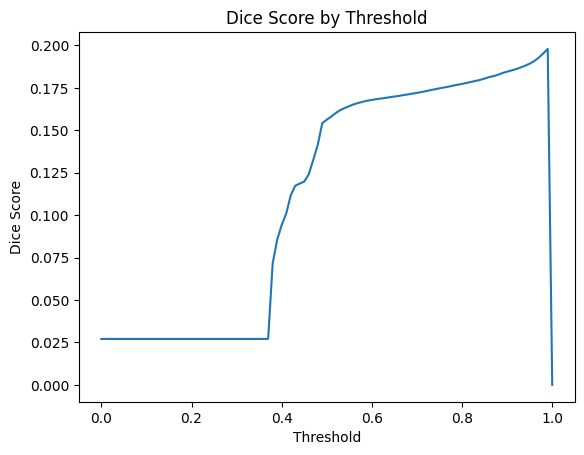

In [21]:
print("best dice score :", best_dice)
print("best threshold:", best_threshold)

plt.plot(values, dice_scores_by_threshold)
plt.xlabel("Threshold")
plt.ylabel("Dice Score")
plt.title("Dice Score by Threshold")
plt.show()

In [22]:
[x.numpy() for x in dice_scores_by_threshold]

[0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.02709445,
 0.027132804,
 0.07160968,
 0.085544035,
 0.0942406,
 0.10089898,
 0.11158528,
 0.1173027,
 0.11860053,
 0.11978917,
 0.12403919,
 0.13257691,
 0.14141569,
 0.15422073,
 0.15627518,
 0.15813069,
 0.16017064,
 0.16190982,
 0.16316596,
 0.16424432,
 0.16531022,
 0.16611692,
 0.16681044,
 0.16746357,
 0.16790117,
 0.16836266,
 0.16871837,
 0.16909413,
 0.1694977,
 0.16991656,
 0.17024866,
 0.1707477,
 0.17114055,
 0.1716017,
 0.17202123,
 0.17256749,
 0.1730698,
 0.17367685,
 0.17417762,
 0.17472726,
 0.17521851,
 0.

Best Predictions :

best 0 : 


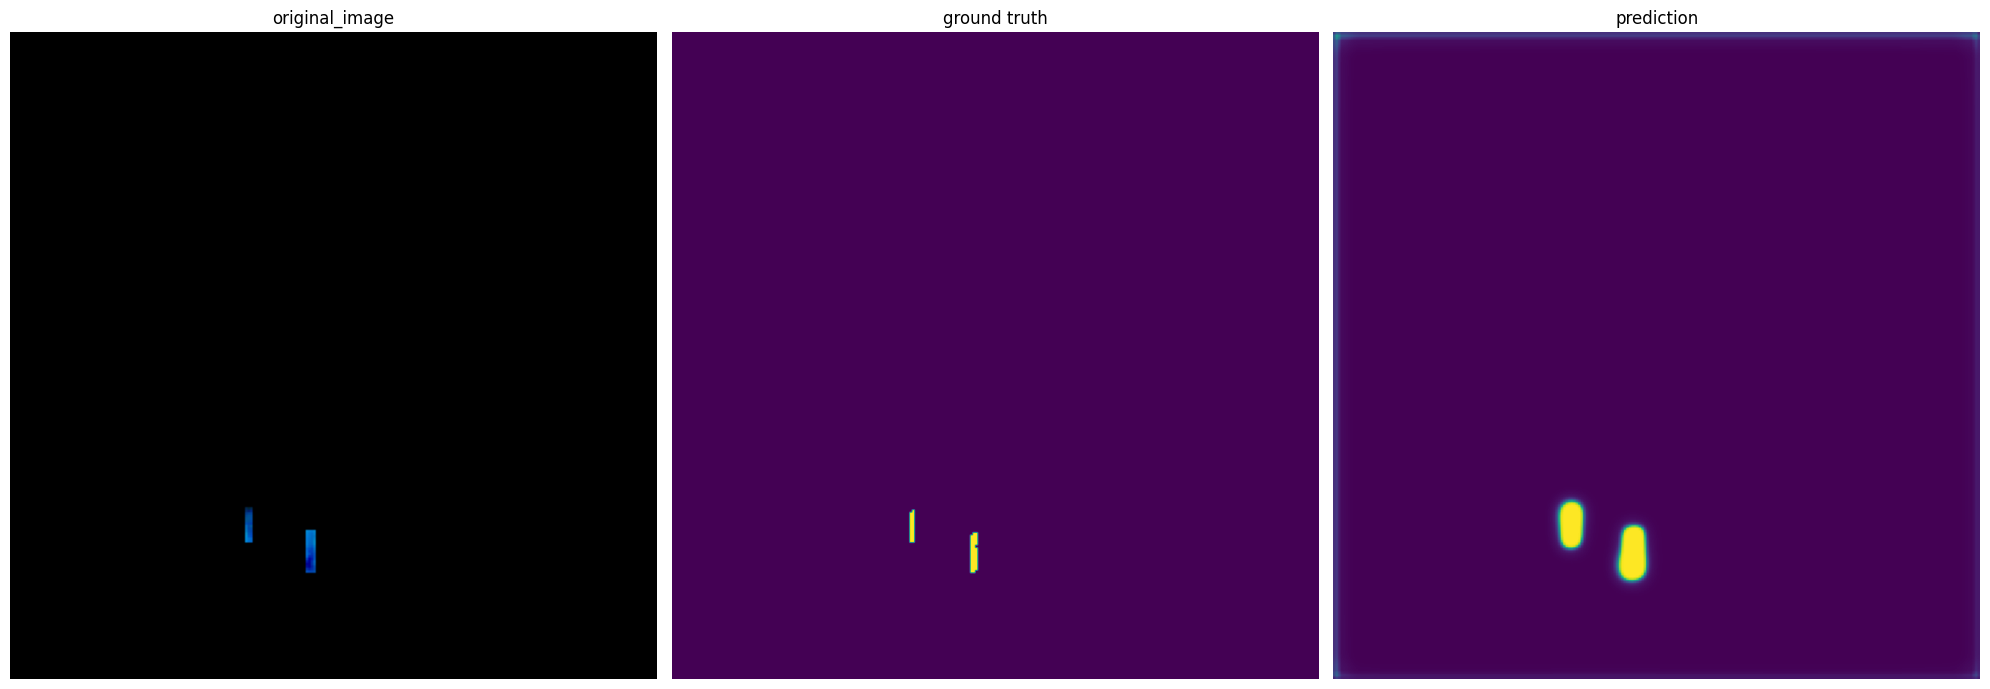

best 1 : 


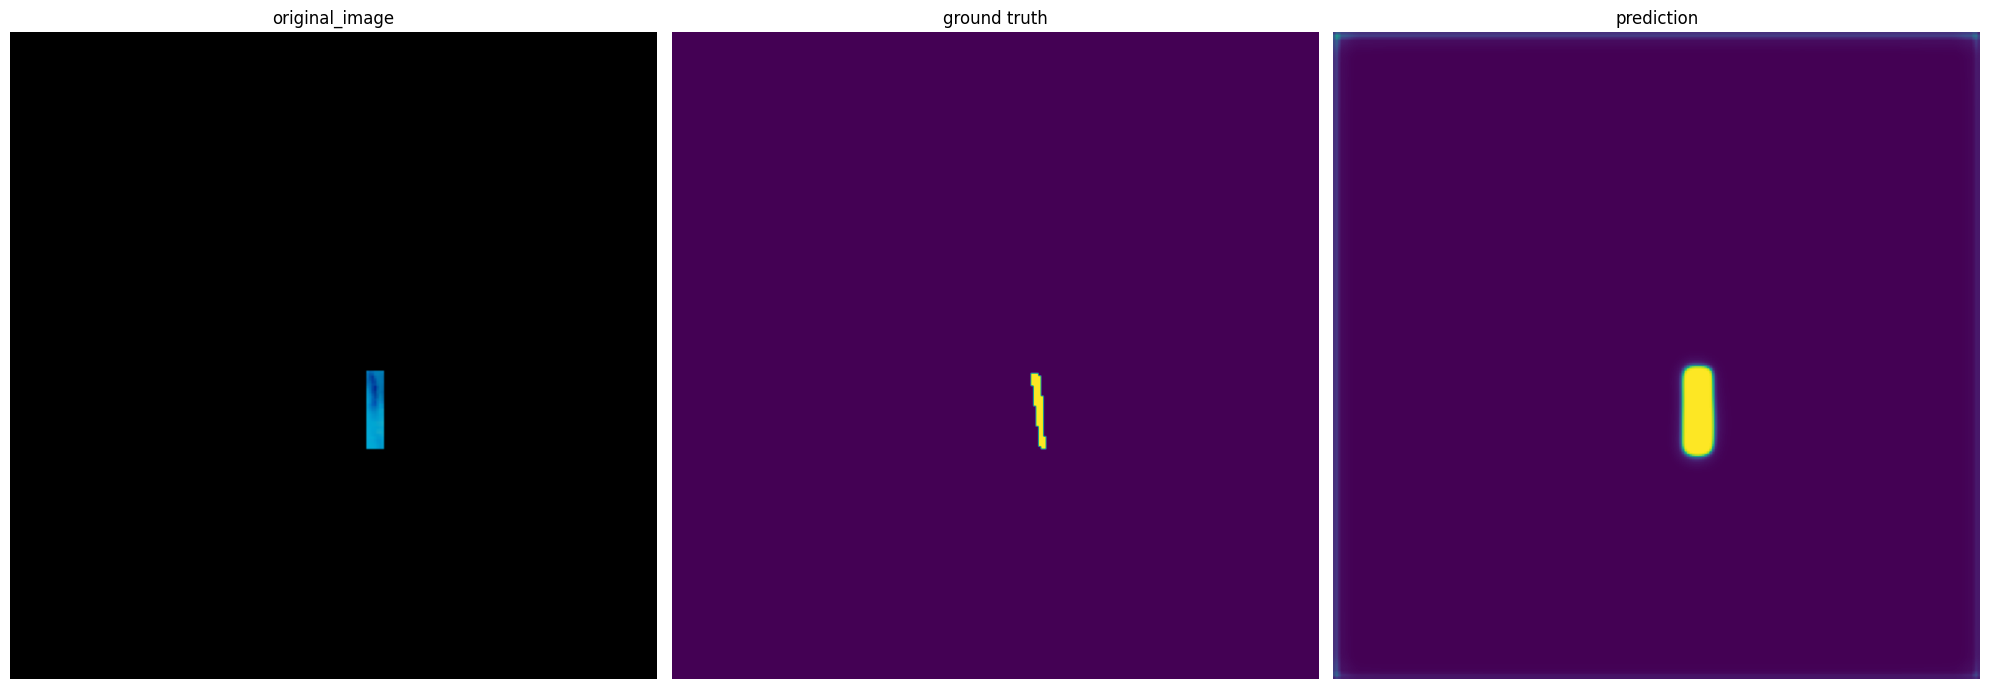

best 2 : 


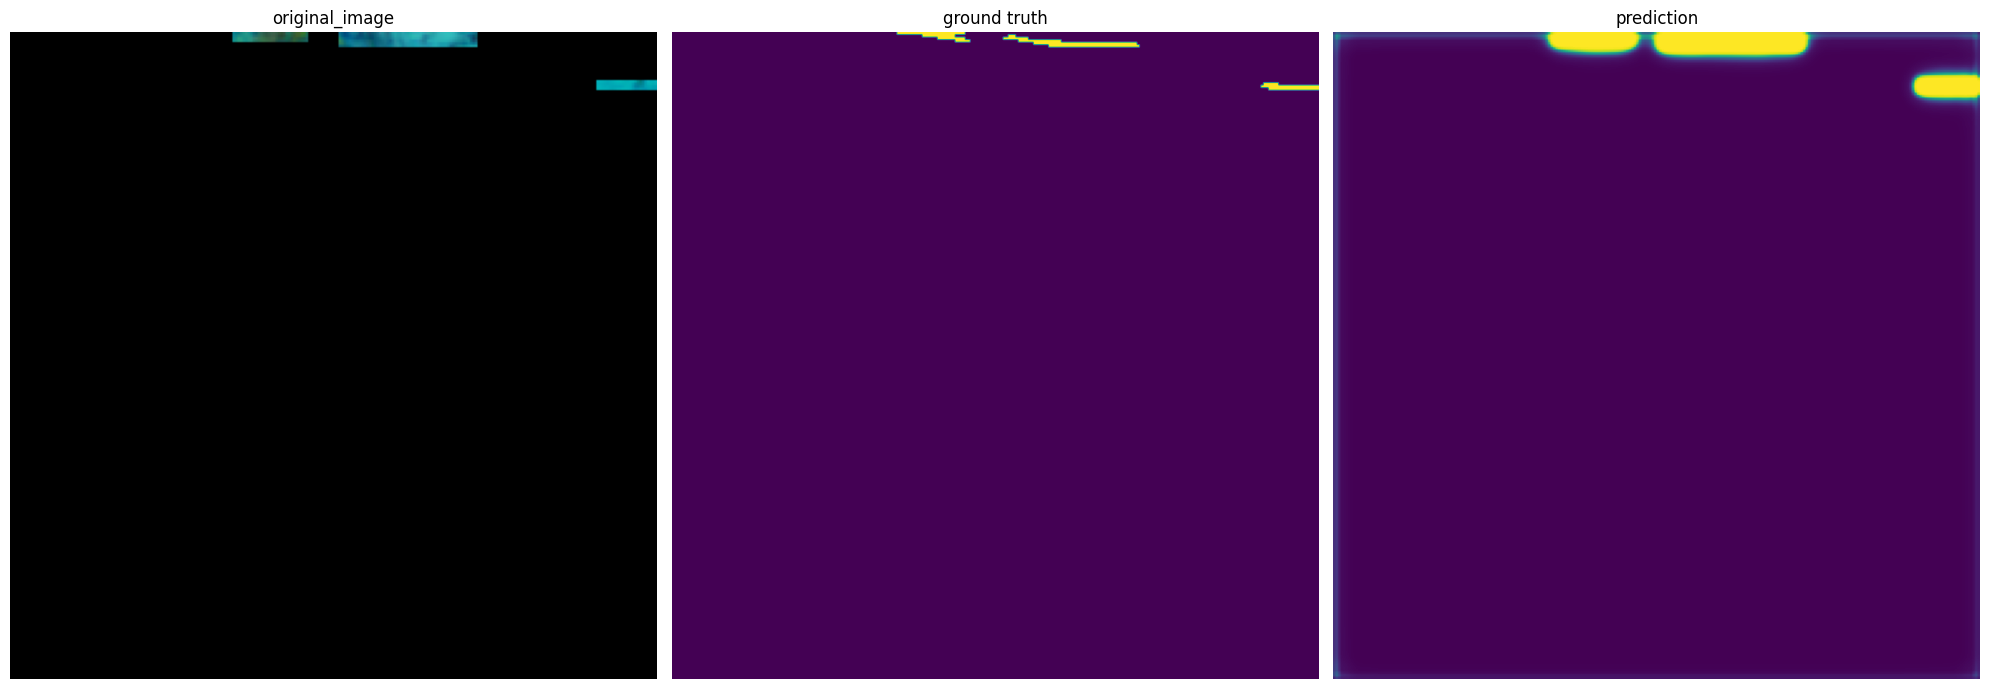

worst predictions :

worst 0 : 


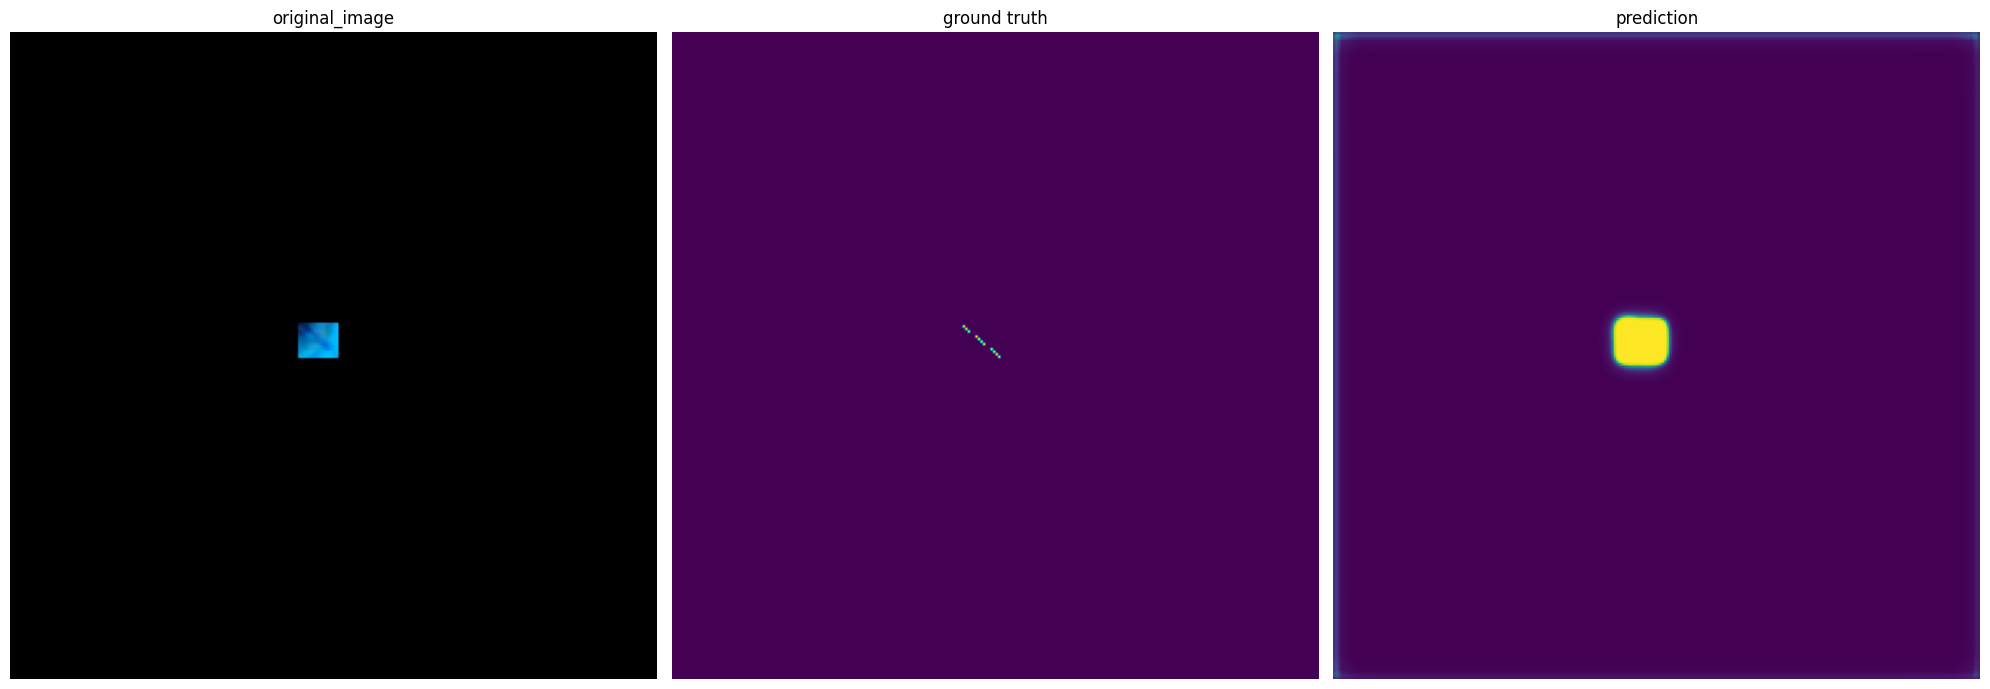

worst 1 : 


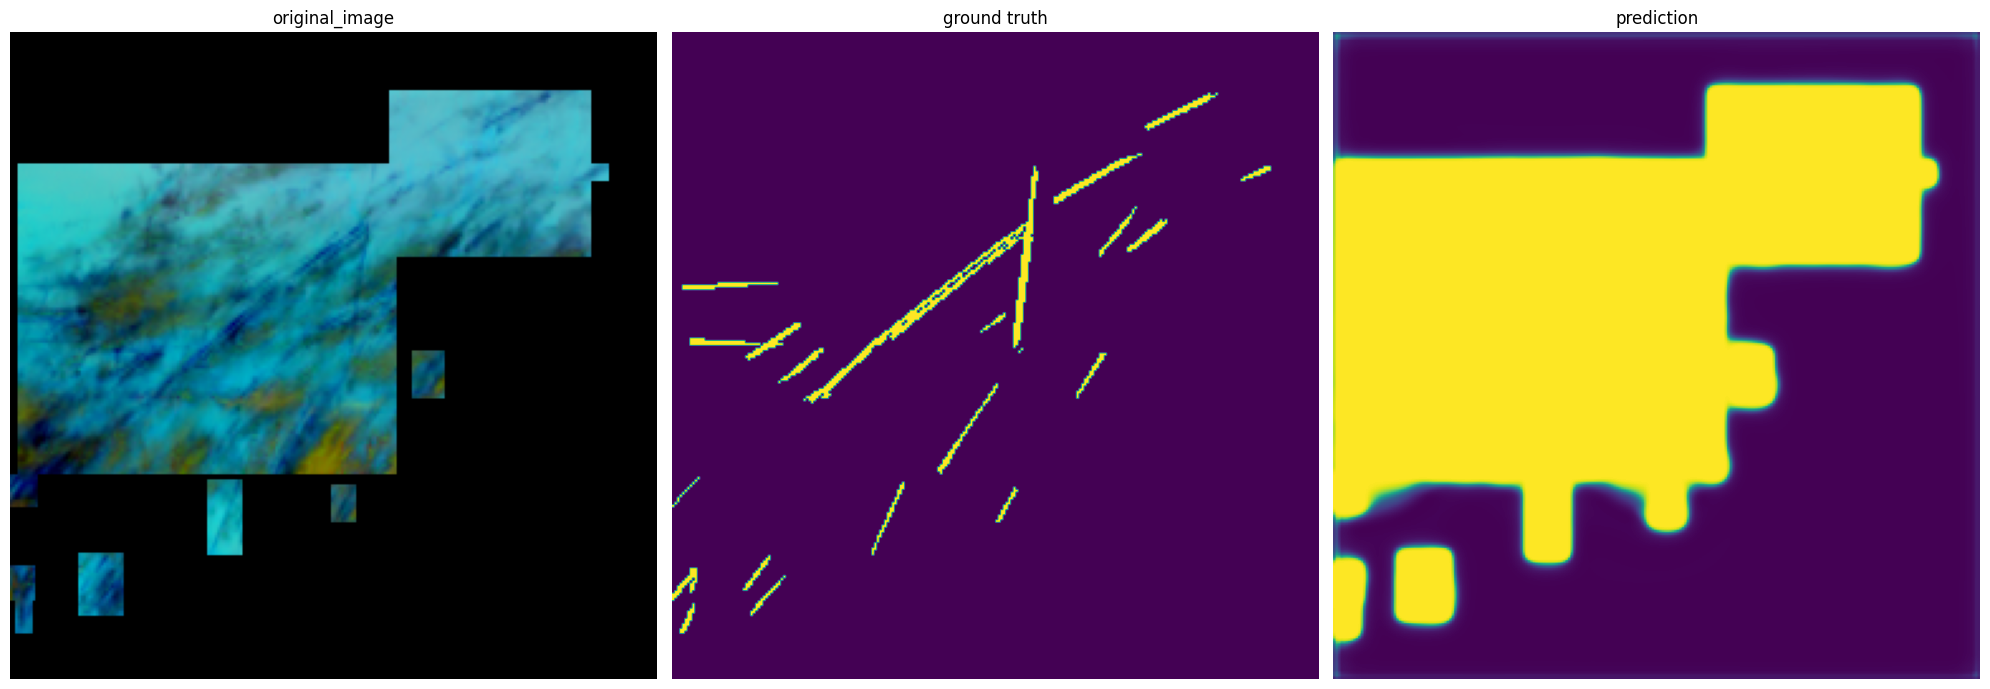

worst 2 : 


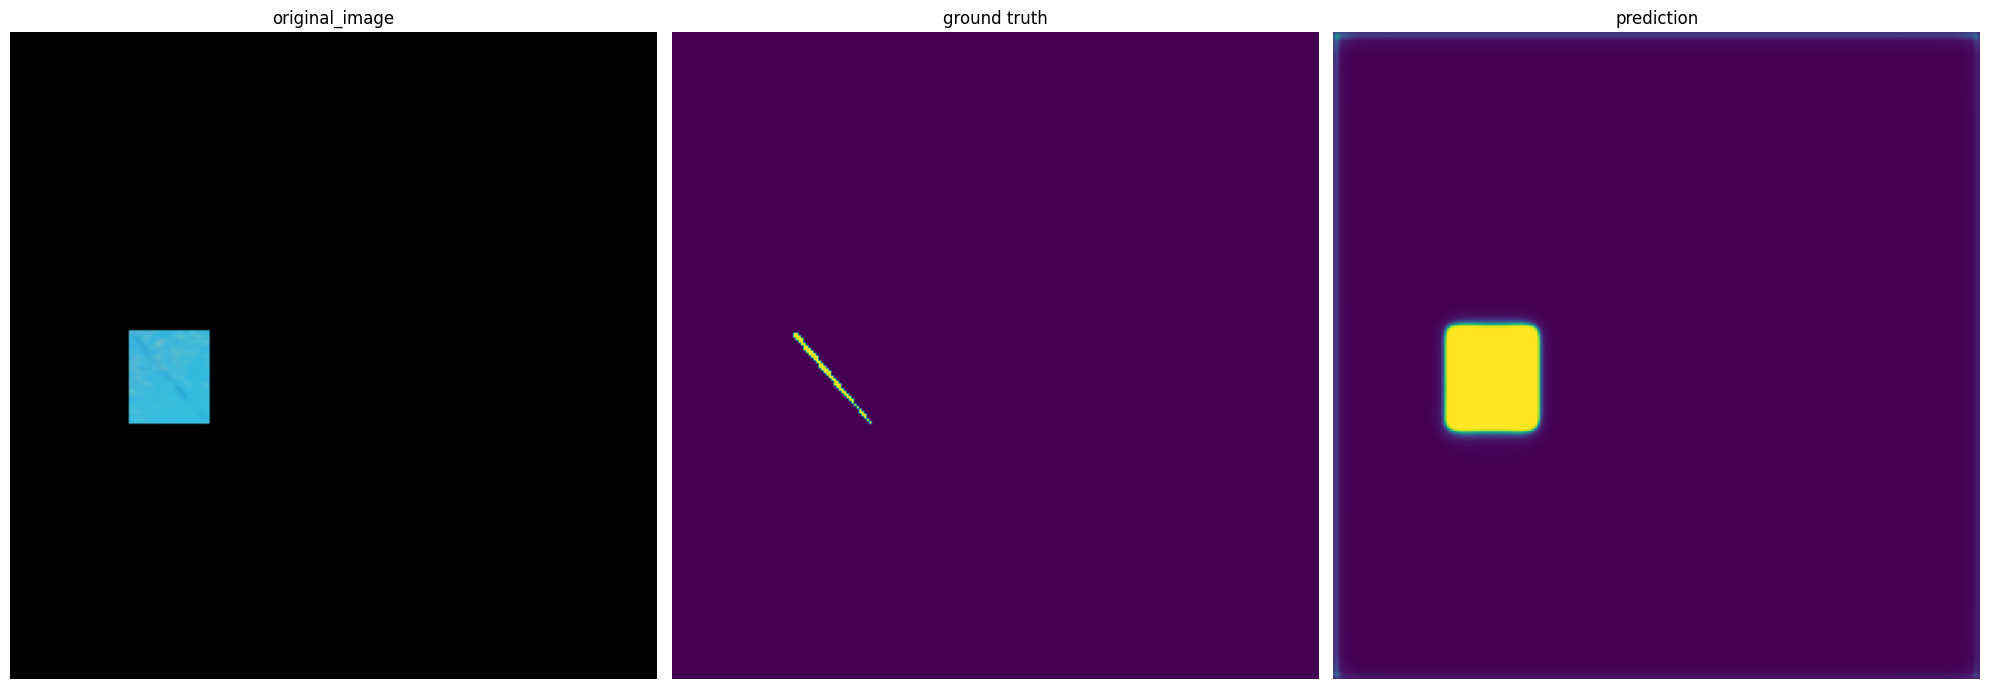

In [19]:
utils.show_predictions(original_images, ground_truths, predictions, best_threshold,0.001, 3)

1. treat batch normalization layer differently for train/val phases(Done!!)

2. sample train_valid set out of the train set and compute train_valid error and metric(dice score) as well as train_train error(Done!!)

3. plot errors(Done!!)

4. measure time, use pbar(Done!!)

5. add to the pipeline the code saving model checkpoints(Done!!)

6. tune threshold(Done!!)

7.  at inference stage, make a function that compares the prediction and the ground truth + outputs a data viz that compare them(Done!!)

8. Xavier initialization,cosine scheduler, device setting(Done!!)

9. use tensorboard to log losses and metrics.(Done!!)

10. data augmentation(Done!!)

11. tensor flow hyperparam optimization tool?(Later)